In [1]:
import torch
from torch import nn
from utils_torch import *
import utils_torch as ut

# Queries, Keys, and Values

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

The attention weight is one only when the query and the key are the same.

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])

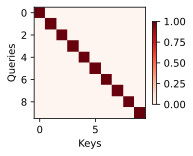

In [4]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Scoring Functions
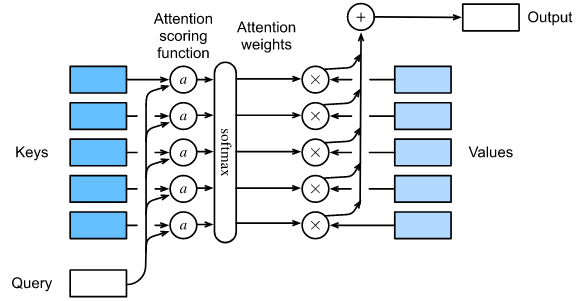

## Dot Product Attention
**Masked Softmax Operation**

In [5]:
def masked_softmax(X, valid_lens):  # @save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Consider a minibatch of two examples of size 2x4, where their valid lengths are 2 and 3, respectively. As a result of the masked softmax operation, values beyond the valid lengths for each pair of vectors are all masked as zero. 

In [6]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4368, 0.5632, 0.0000, 0.0000],
         [0.5975, 0.4025, 0.0000, 0.0000]],

        [[0.2863, 0.5051, 0.2086, 0.0000],
         [0.2672, 0.4198, 0.3130, 0.0000]]])

**Batch Matrix Multiplication**

In [7]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
torch.bmm(Q, K), torch.bmm(Q, K).shape

(tensor([[[4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.],
          [4., 4., 4., 4., 4., 4.]]]),
 torch.Size([2, 3, 6]))

## Scaled Dot-Product Attention

In [8]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        score = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(score, valid_lens)
        # use dropout for model regularization.
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2,6])
attention = DotProductAttention(dropout=0.5)
attention.eval()

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
attention(queries,keys,values,valid_lens).shape

torch.Size([2, 1, 4])

In [11]:
attention.attention_weights

tensor([[[0.4755, 0.5245, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1035, 0.1363, 0.2639, 0.0339, 0.3978, 0.0646, 0.0000, 0.0000,
          0.0000, 0.0000]]])

The attention weights actually vanish for anything beyond the second and sixth column respectively (due to setting valid length to 2 and 6).

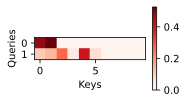

In [12]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Additive Attention
$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}$$


In [13]:
class AdditiveAttention(nn.Module):
    def __init__(self, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries: (batch_size, no. of queries, num_hiddens)
        # keys: (batch_size, no. of key-value pairs, num_hiddens)
        
        # dimension expansion:
        # queries: (batch_size, no. of queries, 1, num_hiddens)
        # keys: (batch_size, 1, no. of key-value pairs, num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
            
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. 
        # scores: (batch_size, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
#         print(attention_weights)
        # values: (batch_size, no. of key-value pairs, value dimension)
        bmm = torch.bmm(self.dropout(self.attention_weights), values)
        return bmm

In [14]:
queries = torch.normal(0, 1, (2, 1, 20))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2,6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()

/home/nancy/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


AdditiveAttention(
  (W_k): LazyLinear(in_features=0, out_features=8, bias=False)
  (W_q): LazyLinear(in_features=0, out_features=8, bias=False)
  (w_v): LazyLinear(in_features=0, out_features=1, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [15]:
attention(queries,keys,values,valid_lens)

tensor([[[-1.6306e+00, -5.1580e-02, -5.9162e-01,  7.8988e-01]],

        [[ 2.4012e-02, -1.2630e+00,  8.1049e-04,  8.5531e-02]]],
       grad_fn=<BmmBackward0>)

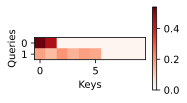

In [16]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# The Bahdanau Attention Mechanism

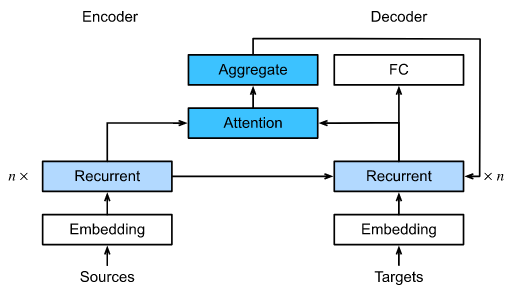

To implement the RNN encoder-decoder with attention, we only need to redefine the decoder

In [17]:
class Seq2SeqAttentionDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.attention = AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)
        
    def init_state(self, enc_outputs, enc_valid_lens):
        # outputs: (num_steps, batch_size, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return outputs.permute(1, 0, 2), hidden_state, enc_valid_lens
        
    def forward(self, X, state):
        """ 
        The state of the decoder is initialized with 
        (i) the hidden states of the last layer of the encoder at all time steps, 
            used as keys and values for attention;
        (ii) the hidden state of the encoder at all layers at the final time step. 
            This serves to initialize the hidden state of the decoder;  
        (iii) the valid length of the encoder, to exclude the padding tokens in attention pooling. 
        """
        # enc_outputs: (batch_size, num_steps, num_hiddens)
        # hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1,0,2)
        outputs, self._attention_weights = [], []
        # x: (batch_size, embed_size)
        # for each step (word)
        for x in X:
            """At each decoding time step, the hidden state of the last layer of the decoder, 
            obtained at the previous time step, is used as the query of the attention mechanism."""
            # hidden_state[-1]: (batch_size, num_hiddens) decoder上一个时刻的最后一层的输出
            # query: (batch_size, 1, num_hiddens)
            # 
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context: (batch_size, 1, num_hiddens)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            """Both the output of the attention mechanism and the input embedding are 
            concatenated to serve as the input of the RNN decoder."""
            # Concatenate on the feature dimension
            x = torch.cat((context,torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1,0,2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # outputs: (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1,0,2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [18]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)

## Training

In [19]:
data = MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

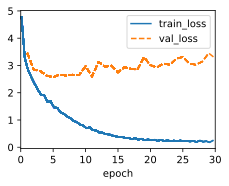

In [20]:
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)
trainer = Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

In [21]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(data.build(engs, fras), cpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


Let’s visualize the attention weights when translating the last English sentence. We see that each query assigns non-uniform weights over key-value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

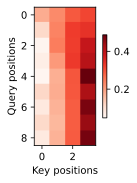

In [22]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), cpu(), data.num_steps, True)

attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

When predicting a token, if not all the input tokens are relevant, the RNN encoder-decoder with the Bahdanau attention mechanism selectively aggregates different parts of the input sequence. This is achieved by **treating the state (context variable) as an output of additive attention pooling**. 

In the RNN encoder-decoder, the Bahdanau attention mechanism treats the **decoder hidden state at the previous time step** as the ***query***, and the **encoder hidden states at all the time steps** as both the ***keys*** and ***values***.

# Multi-Head Attention

We choose the scaled dot-product attention for each head of the multi-head attention.

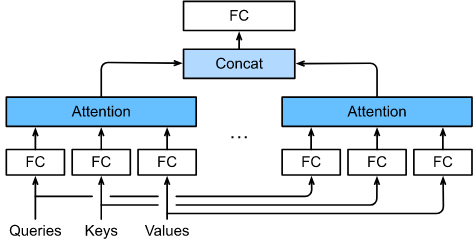

Note that $h$ heads can be computed in parallel if we set the number of outputs of linear transformations for the query, key, and value to $p_qh=p_kh=p_vh=p_o$. In the following implementation, $p_o$ is specified via the argument `num_hiddens`.

In [27]:
class MultiHeadAttention(Module):
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        print("queries:",queries.shape, "keys:",keys.shape,"values:",values.shape,"valid_lens:",valid_lens.shape)
        # output: (batch_size * num_heads, no. of queries, num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)
    
    #To allow for parallel computation of multiple heads, the above MultiHeadAttention class uses two transposition methods
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # input X: (batch_size, no. of queries or key-value pairs,num_hiddens). 
        # output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
        
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        
        # output X: (batch_size, num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)
        
        # output: (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])
    
    #  the transpose_output method reverses the operation of the transpose_qkv method.
    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)
        

In [29]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3,2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

queries: torch.Size([10, 4, 20]) keys: torch.Size([10, 6, 20]) values: torch.Size([10, 6, 20]) valid_lens: torch.Size([10])


torch.Size([2, 4, 100])

In [25]:
torch.repeat_interleave(valid_lens, repeats=num_heads, dim=0)

tensor([3, 3, 3, 3, 3, 2, 2, 2, 2, 2])